In [10]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view as window
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageOps
import random

In [11]:
def get_train_images(aspect = (100, 70)):
    images = []

    for filename in glob.glob('images/*.jpg'): #assuming gif
        im = Image.open(filename)
        im = ImageOps.fit(im, aspect)
        im = np.array(im).astype(np.float32) / 255
        images.append(im)

    plt.figure(figsize = (8, 8))

    _, axarr = plt.subplots(2, 2) 
    axarr = axarr.flatten()


    for i, im in enumerate(random.sample(images, 4)):
        axarr[i].imshow(im)
        axarr[i].axis('off')
        axarr[i].margins(0, 0)

    plt.subplots_adjust(wspace=.05, hspace=.05, left=0, right=1, bottom=0, top=1)

    return images

In [12]:
class PatternMatcher:
    def __init__(self, pattern_shape, num_patterns, pattern_trainer, max_average = None):
        self.pattern_shape = pattern_shape
        self.num_patterns = num_patterns

        self.pattern_size = np.prod(self.pattern_shape)

        self.whole_shape = [num_patterns]
        self.whole_shape.extend(pattern_shape)

        self.patterns = np.array([pattern_trainer.get_example(self) for i in range(self.num_patterns)])
        self.average_sums = np.ones((num_patterns,)) * .1

        self.max_average = max_average

    def train_patterns(self, training_data):
        if len(training_data.shape) == len(self.whole_shape) - 1:
            training_data = np.expand_dims(training_data, axis = 0)

        # num_patterns, 0,         pattern_shape
        # 0,            num_datas, pattern_shape
        _patterns = np.expand_dims(self.patterns, axis = 1)
        _data     = np.expand_dims(training_data, axis = 0)

        # out pattern, data
        differences = abs(_patterns - _data)
        differences = np.sum(differences, axis = tuple(range(2, _data.ndim)))
        differences /= self.pattern_size
        differences = 1 - differences

        nearest_matches = np.argmax(differences, axis = 0)

        self.apply_training_data(training_data, nearest_matches)

    def apply_training_data(self, training_data, nearest_matches):
        # TODO: test the validity of this method
        new_sums = np.array(list(self.average_sums))

        for i, match in enumerate(nearest_matches):
            new_sums[match] += 1
            new_sum = self.average_sums[match] + 1
            old_amt = self.average_sums[match] / new_sum
            new_amt = 1 / new_sum

            self.patterns[match] = (self.patterns[match] * old_amt) + (training_data[i] * new_amt)

        self.average_sums = new_sums if self.max_average == None else np.minimum(new_sums, self.max_average)




    def most_similar(self, pattern):
        return np.argmax(self.get_similarities(pattern))


    def get_similarities(self, pattern):
        diffs = np.sum(abs(self.patterns - pattern), axis = tuple(range(pattern.ndim)))
        diffs /= self.pattern_size
        return 1 - diffs

In [13]:
class ConvolutionalPatternMatcher(PatternMatcher):
    
    def get_activation_map(self, image):# image must be 0-1!
        
        activation_map = np.zeros(
            (image.shape[0] - self.pattern_shape[0] + 1,
             image.shape[1] - self.pattern_shape[1] + 1,
             self.num_patterns))
        
        image_windows = np.squeeze(window(
            image, 
            (self.pattern_shape[0], self.pattern_shape[1],
            image.shape[-1])), axis = -4)

        for i, pattern in enumerate(self.patterns):
            activation_map[:, :, i] = 1 - (
                np.sum(np.abs(image_windows - pattern), axis = (2, 3, 4))
                ) / self.pattern_size

        return activation_map
    
    def undo_activation_map(self, activation_map):

        image = np.zeros(
            (activation_map.shape[0] - 1 + self.pattern_shape[0],
             activation_map.shape[1] - 1 + self.pattern_shape[1],
             self.pattern_shape[-1]))
        
        division_sum = np.zeros(
            image.shape
        )

        activation_map = activation_map == np.repeat(
            np.expand_dims(
                np.max(
                    activation_map, axis = -1
                    ),
                    -1
                ),
                activation_map.shape[-1], axis = -1
            )
        
        for n, pattern in enumerate(self.patterns):
            x = 0
            for i in range(activation_map.shape[0]):
                y = 0
                for j in range(activation_map.shape[1]):
                    try:
                        image[x : x + self.pattern_shape[0], y : y + self.pattern_shape[1]] += pattern * activation_map[i, j, n]
                        division_sum[x : x + self.pattern_shape[0], y : y + self.pattern_shape[1]] += activation_map[i, j, n]
                    except:
                        print(x, x + self.pattern_shape[0], y, y + self.pattern_shape[1])
                        print(pattern.shape)
                        print(n)
                        print(activation_map[i, j, n])
                    y += 1
                x += 1

        return image / division_sum

In [14]:
class BasicConvolutionalTrainer:
    def __init__(self, images):
        self.images = images

    def train(self, p, batches, batch_size):
        for i in range(batches):
            p.train_patterns(self.get_examples(batch_size, p))

    def get_examples(self, num_examples, p):
        return np.array([self.get_example(p) for i in range(num_examples)])
    
    def get_example(self, p):
        width  = p.pattern_shape[0]
        height = p.pattern_shape[1]
    
        image = random.choice(self.images)
        chunk = image[random.randint(0, image.shape[0] - width):, 
                      random.randint(0, image.shape[1] - height):]
        chunk = chunk[:width, :height]
        return chunk
        

In [ ]:
class StrategicConvolutionalTrainer:
    def __init__(self, images):
        self.images = images

    def train(self, p, batches, batch_size):
        for i in range(batches):
            scale_maps = self.get_scale_maps(p)
            p.train_patterns(self.get_examples(batch_size, p))

    def get_examples(self, num_examples, p):
        return np.array([self.get_example(p) for i in range(num_examples)])
    
    def get_example(self, p):
        width  = p.pattern_shape[0]
        height = p.pattern_shape[1]
    
        image = random.choice(self.images)
        chunk = image[random.randint(0, image.shape[0] - width):, 
                      random.randint(0, image.shape[1] - height):]
        chunk = chunk[:width, :height]
        return chunk
    
    def get_scale_maps(self, p):
        return np.array(
            [np.sum(np.abs(
                p.undo_activation_map(
                    p.get_activation_map(image)
                    )
                    - image), axis = -1) 
                for image in self.images])
        

<Figure size 800x800 with 0 Axes>

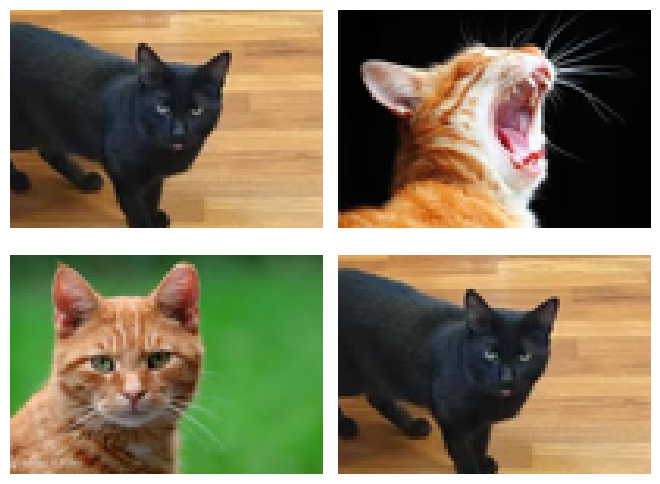

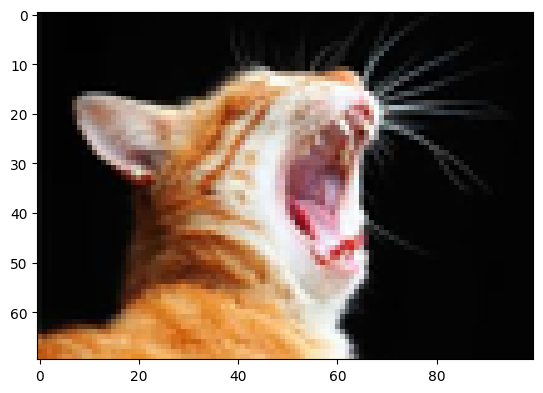

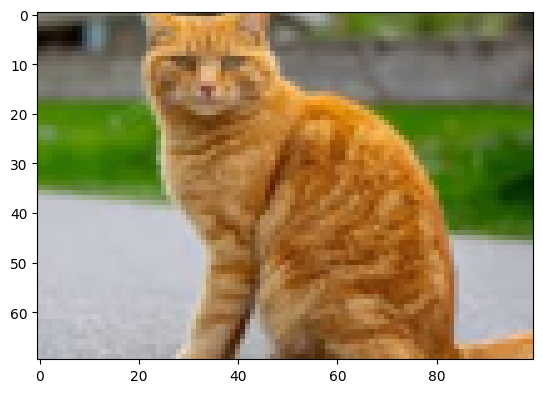

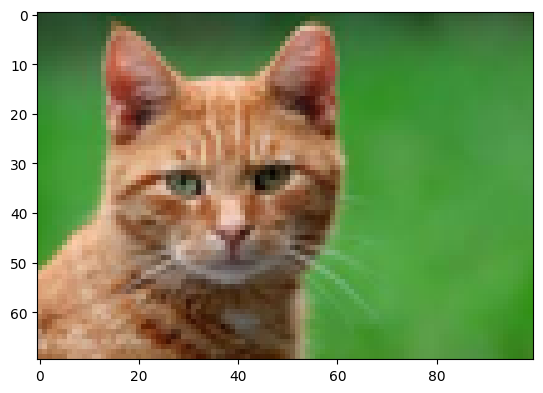

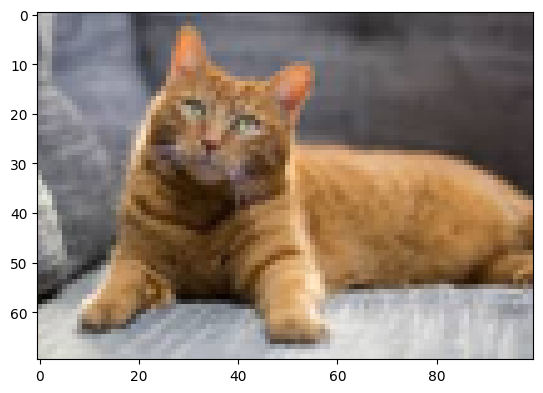

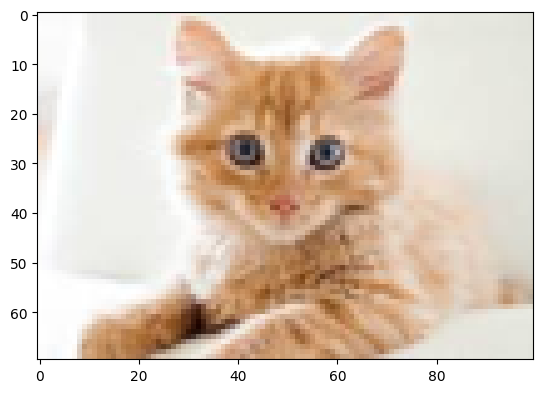

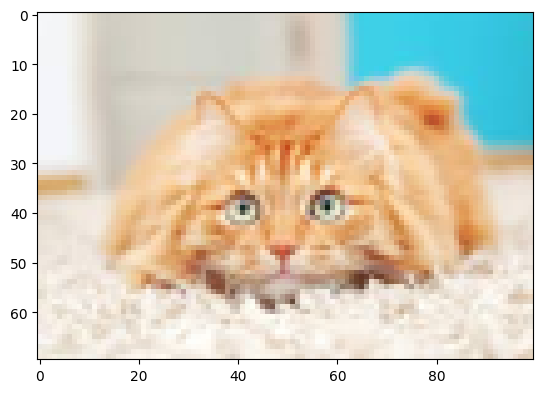

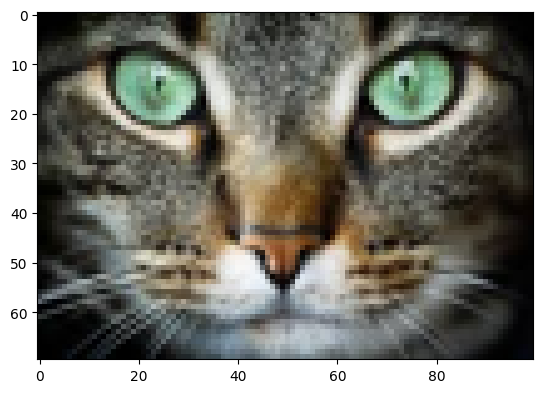

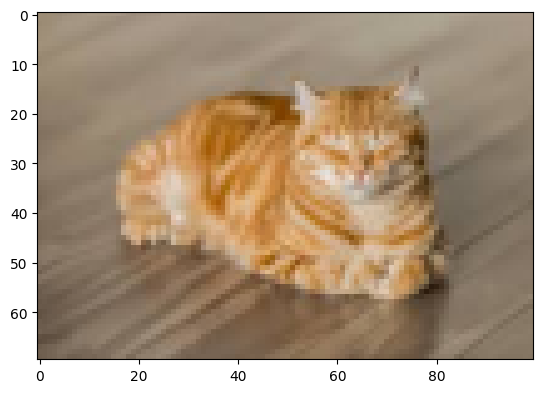

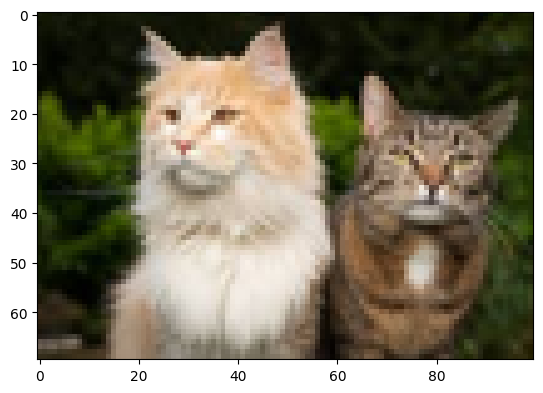

In [16]:
images = get_train_images()
for image in images:
    plt.imshow(image)
    plt.show()

In [26]:
l1_trainer = BasicConvolutionalTrainer(images)
p = ConvolutionalPatternMatcher((4, 4, 3), 100, l1_trainer, 200)

In [34]:
l1_trainer.train(p, 500, 100)

In [27]:
l2_images = [p.get_activation_map(image) for image in images]

In [28]:
l2_trainer = BasicConvolutionalTrainer(l2_images)
p2 = ConvolutionalPatternMatcher((4, 4, 100), 100, l2_trainer, 200)

In [22]:
l2_trainer.train(p2, 500, 100)

In [29]:
l3_images = [p2.get_activation_map(image) for image in l2_images]

In [30]:
l3_trainer = BasicConvolutionalTrainer(l3_images)
p3 = ConvolutionalPatternMatcher((4, 4, 100), 100, l3_trainer, 200)

In [ ]:
l3_trainer.train(p3, 500, 100)

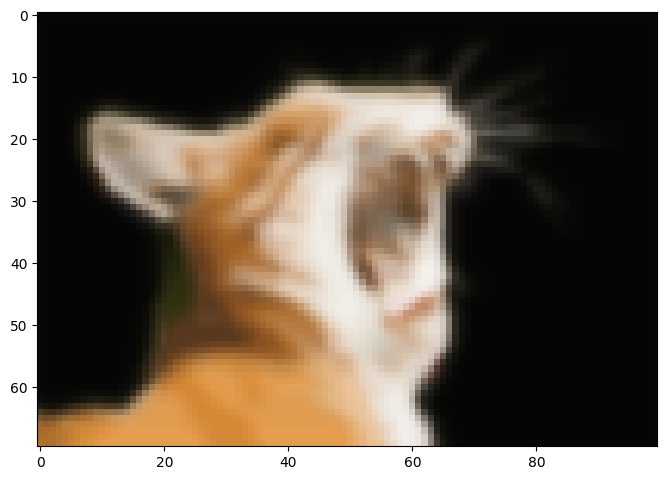

In [35]:
for i in images[1:2]:
    act_map = p.get_activation_map(i)
    image = p.undo_activation_map(act_map)
    plt.figure(figsize = (8, 8))
    plt.imshow(image)

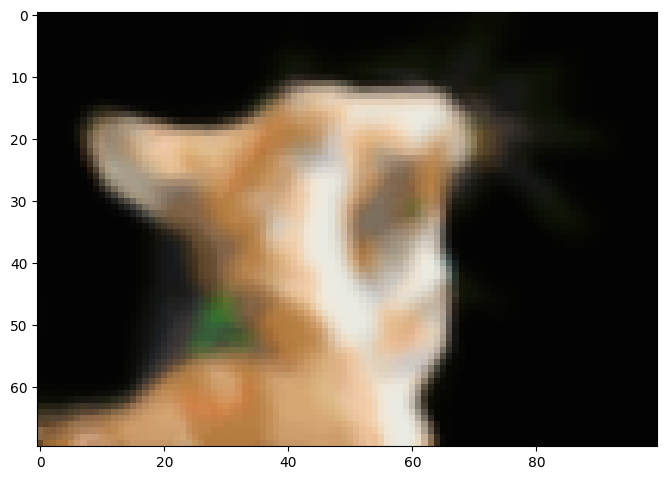

In [32]:
for i in images[1:2]:
    act_map = p.get_activation_map(i)
    act_map = p2.get_activation_map(act_map)
    act_map = p2.undo_activation_map(act_map)
    image = p.undo_activation_map(act_map)
    plt.figure(figsize = (8, 8))
    plt.imshow(image)

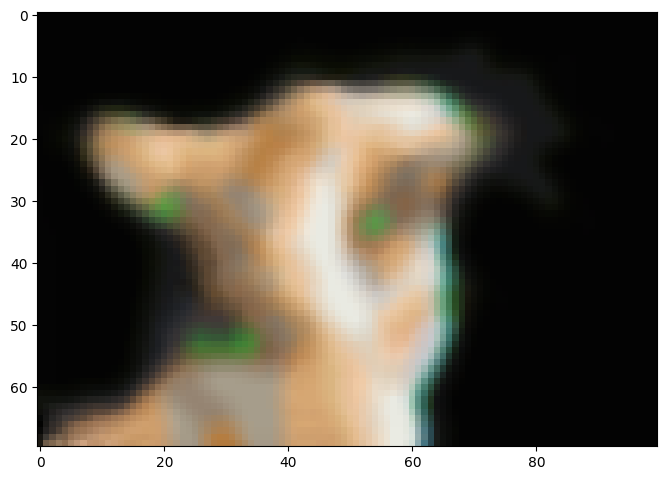

In [33]:
for i in images[1:2]:
    act_map = p.get_activation_map(i)
    act_map = p2.get_activation_map(act_map)
    act_map = p3.get_activation_map(act_map)
    act_map = p3.undo_activation_map(act_map)
    act_map = p2.undo_activation_map(act_map)
    image = p.undo_activation_map(act_map)
    plt.figure(figsize = (8, 8))
    plt.imshow(image)

In [24]:
tiny = ConvolutionalPatternMatcher((1,1,3), 5, l1_trainer)

In [ ]:
l1_trainer.train(tiny, 500, 100)

# for pattern in p.patterns:
#     plt.figure(figsize = (.2, .2))
#     plt.axis('off')
#     plt.imshow(pattern)
#     plt.show()

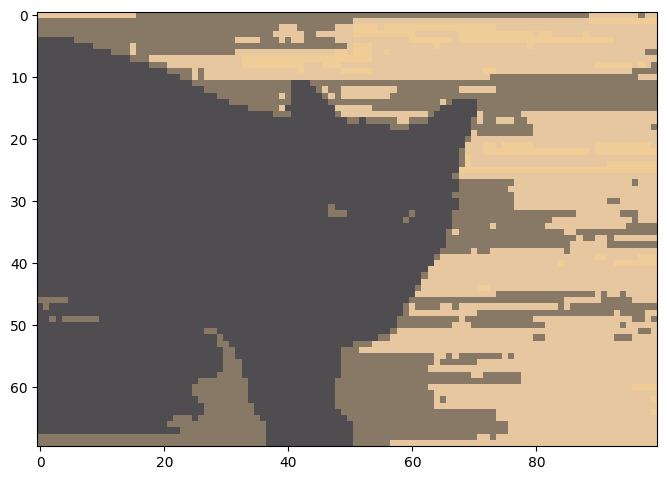

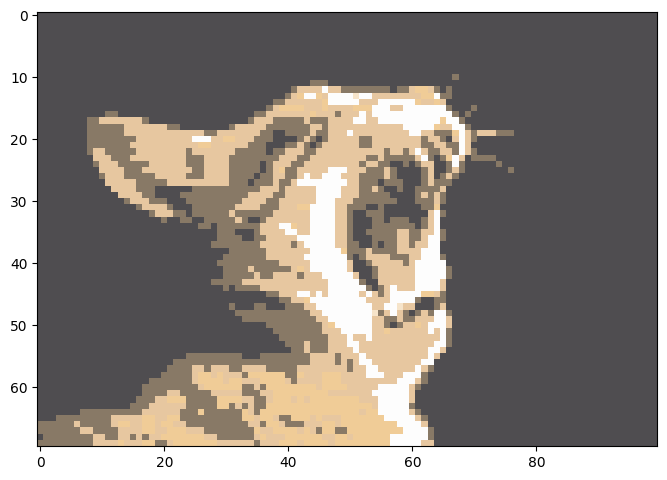

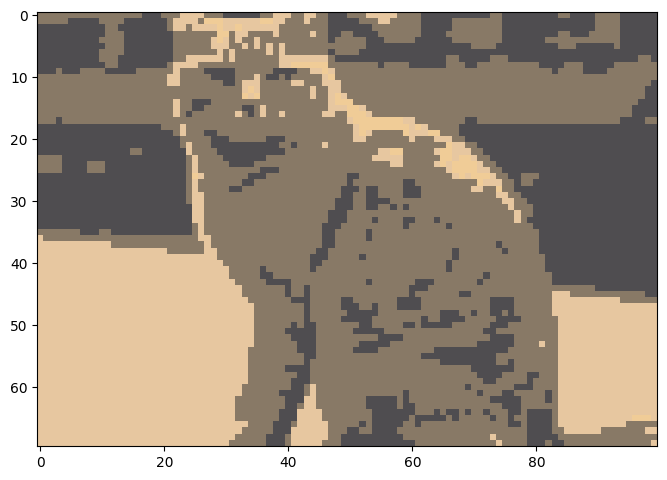

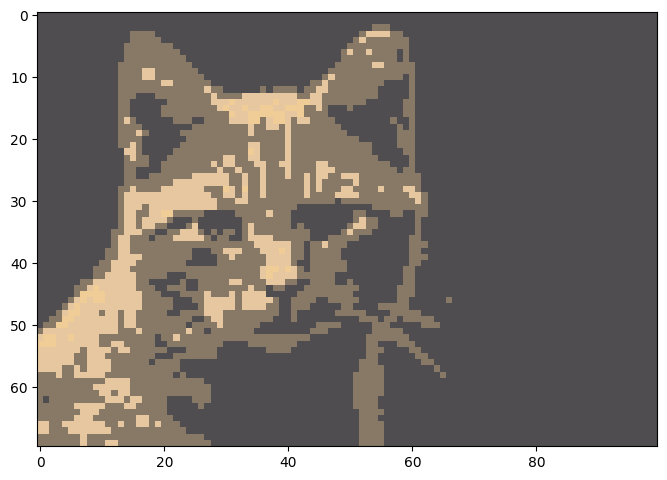

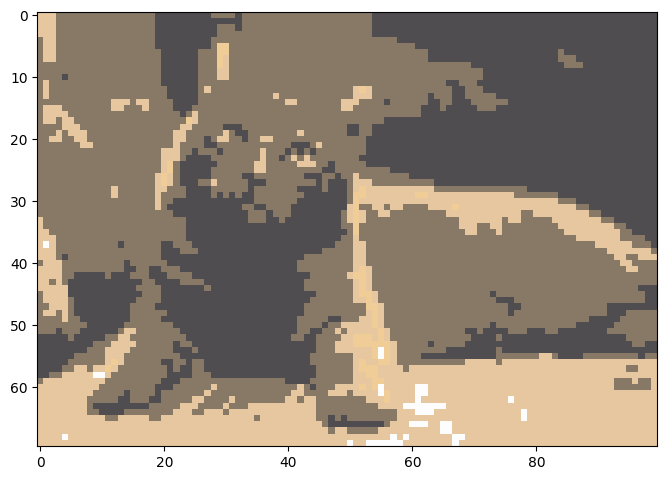

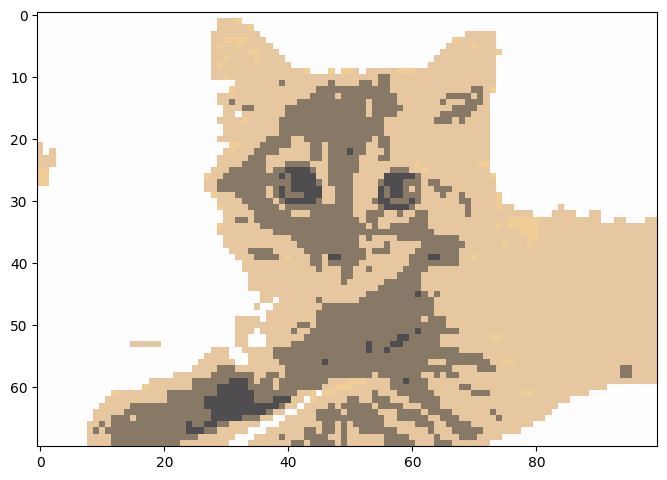

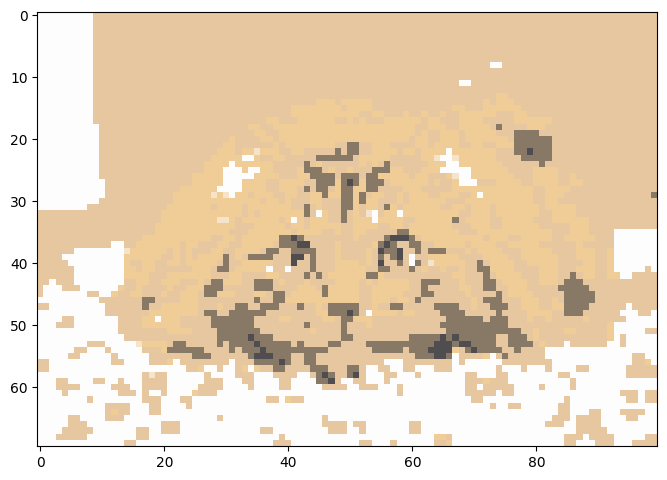

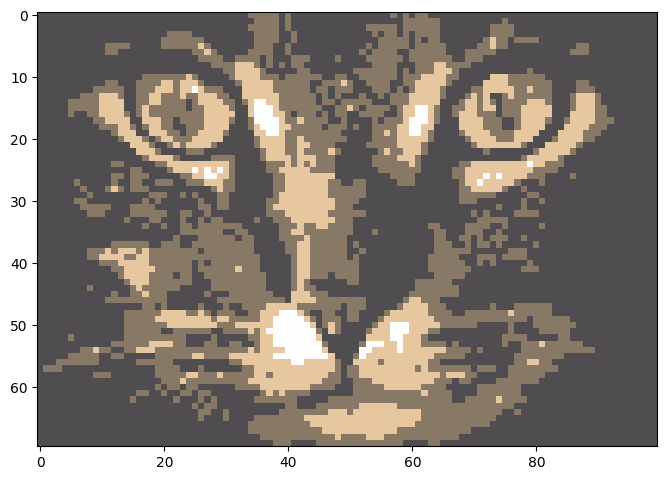

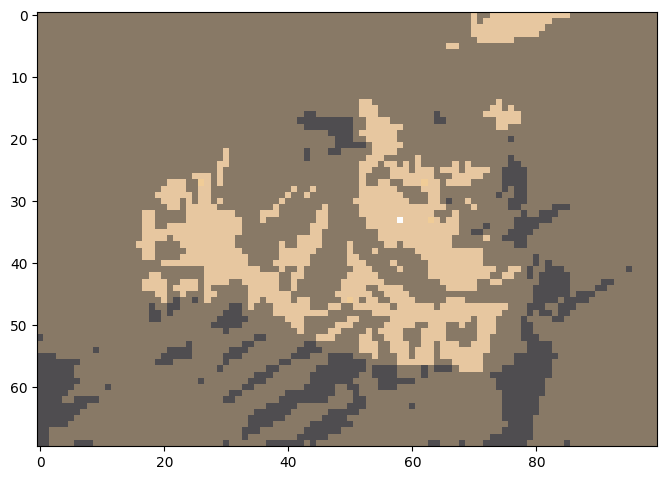

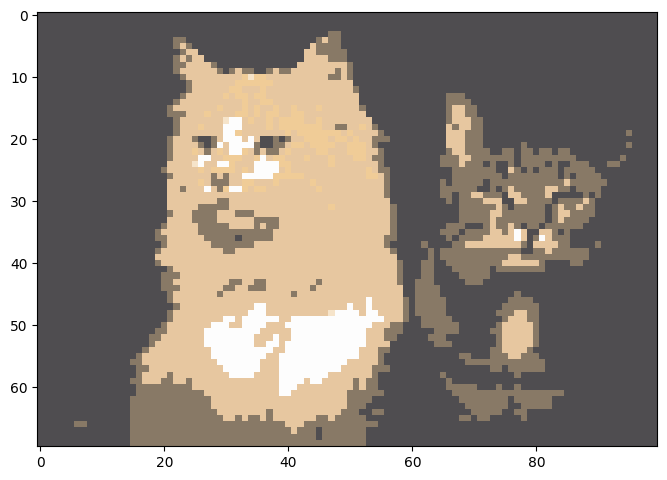

In [25]:
for i in images:
    act_map = tiny.get_activation_map(i)
    image = tiny.undo_activation_map(act_map)
    plt.figure(figsize = (8, 8))
    plt.imshow(image)